# Проект: вариант 2
## Задание 1. A/B–тестирование
### 1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### 1.2 Входные данные

В качестве входных данных вы имеете 4 csv-файла:

groups.csv – файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
groups_add.csv – дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных  
active_studs.csv – файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.   
checks.csv – файл с информацией об оплатах пользователей в дни проведения эксперимента.  

### 1.3 Вопросы

Предлагаем вам ответить на следующие вопросы:

На какие метрики вы смотрите в ходе анализа и почему?  
Имеются ли различия в показателях и с чем они могут быть связаны?  
Являются ли эти различия статистически значимыми?  
Стоит ли запускать новую механику на всех пользователей?  
Данный список вопросов не является обязательным, и вы можете при своём ответе опираться на собственный план.

In [1]:
# Импортируем нужные библиотеки
import pandas as pd
import requests
import urllib
import json

from datetime import datetime
from datetime import timedelta
import matplotlib as mpl
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import scipy.stats as st
from scipy.stats import bootstrap

1. Подгружаем входные данные

In [2]:

from urllib.parse import urlencode
tables = [['groups', 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'],
         ['group_add', 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'],
         ['active_studs', 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'],
         ['checks', 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA']]

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
#создаем цикл для выгрузки каждой таблицы из tables
for i in tables:
    public_key = i[1]
    table_name = i[0]
    # Получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']


    #Загрузка данных в DataFrame и присваивание имени таблицы:
    if i[0] == 'groups' or i[0] == 'checks':
        locals()[f"{table_name}"] = pd.read_csv(download_url, sep=';', error_bad_lines=False, comment='#' , encoding='cp1251')
    else:
        locals()[f"{table_name}"] = pd.read_csv(download_url, sep=',', error_bad_lines=False, comment='#' , encoding='cp1251')

In [3]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [7]:
active_studs.nunique()

student_id    8341
dtype: int64

In [8]:
group_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [9]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [10]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [11]:
checks.shape

(541, 2)

In [12]:
checks.groupby('student_id').rev.sum()

student_id
1627        990.0
3185        690.0
25973       690.0
26280       690.0
100300      990.0
            ...  
5645737    1900.0
5651566    1900.0
5662322    1900.0
5681918    1900.0
5740903    1900.0
Name: rev, Length: 541, dtype: float64

2. Предварительное изучение данных

In [13]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [14]:
active_studs.nunique()

student_id    8341
dtype: int64

In [15]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [16]:
checks.nunique()

student_id    541
rev            39
dtype: int64

In [17]:
group_add.groupby('grp').id.count()

grp
A    22
B    70
Name: id, dtype: int64

In [18]:
group_add.nunique()

id     92
grp     2
dtype: int64

In [19]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [20]:
groups.groupby('grp').id.count()

grp
A    14671
B    59813
Name: id, dtype: int64

In [33]:
# Обьединяем таблицу с чеками и активными студентами
paid_students_all = checks.merge(active_studs, on='student_id' ,  how = 'left',  indicator=True) 


In [34]:
# Выбираем студентов которые совершали покупки и при этом не были активными в период эксперимента
paid_students_all_not_active = paid_students_all[paid_students_all['_merge'] == 'left_only']

In [35]:
paid_students_all_not_active

,student_id,rev,_merge
1,3185,690.0,left_only
2,25973,690.0,left_only
3,26280,690.0,left_only
5,100645,630.0,left_only
6,102534,580.0,left_only
...,...,...,...
508,5291900,199.0,left_only
512,5331842,290.0,left_only
521,5486319,199.0,left_only
530,5562806,398.0,left_only


#### Вывод по изучению данных:
- Итак мы имеем две выборки, неравноценные по размерам, контрольная группа меньше целевой группы в 4 раза.   
- Нам дана информация об оплатах пользователей в дни проведения эксперимента. В условиях не сказано является ли эта информация суммой по чеку или суммарными покупками пользователя. В дальнейших вычислениях я буду принимать каждую строчку таблицы checks за один чек: т.е. изучив данные, если пользователь и совершал покупку то только одну.  
- Нас интересуют только те студенты, которые вообще заходили на сайт в дни эксперимента, так как они могли оценить новую механику оплаты услуг на сайте. Таким образом, мы можем отбросить неактивных пользователей, входящих в выборки и совершавших покупки. 


In [20]:
# Обьединяем таблицу с группами и активными студентами, отбрасываем неактивных пользователей и пользователей,
# не являющихся участниками эксперимента. 
test_students = active_studs.merge(groups, left_on='student_id' , right_on='id', how = 'left').dropna()

In [21]:
test_students

,student_id,id,grp
0,581585,581585.0,A
2,3276743,3276743.0,B
3,4238589,4238589.0,A
4,4475369,4475369.0,B
5,5481015,5481015.0,B
...,...,...,...
8336,1794344,1794344.0,B
8337,296883,296883.0,B
8338,3598448,3598448.0,B
8339,3610547,3610547.0,B


In [22]:
test_students = test_students[['student_id', 'grp']]

In [23]:
test_students.groupby('grp').student_id.count()

grp
A    1535
B    6793
Name: student_id, dtype: int64

In [24]:
test_students.shape

(8328, 2)

#### Выбор метрик
- В связи с тем что изменения которые мы вносим в приложение, касаются механики оплаты услуг на сайте. То есть пользователь уже выбрал продукт и принял решение о покупке, следовательно новая механика может повлиять на конверсию, а именно была ли завершена покупка. CR -  целевая метрика.
- В качестве дополнительной метрики выбираем средний чек, чтоб понять не повлияла ли новая механика на средний чек. Он не должен уменьшиться.



#### 1. Анализ CR:

In [25]:
# Объединяем таблицу с активными студентами,участвующими в тесте с информацией по чекам.
AB_data = test_students.merge(checks, on='student_id', how = 'left')

In [26]:
AB_data.head()

,student_id,grp,rev
0,581585,A,NaN
1,3276743,B,NaN
2,4238589,A,NaN
3,4475369,B,NaN
4,5481015,B,NaN


In [27]:
# Создаем категориальный столбец показывающий была ли совершена покупка у этого студента
AB_data['is_rev'] = AB_data.rev.notna().astype(int)

In [28]:
AB_data.head()

,student_id,grp,rev,is_rev
0,581585,A,NaN,0
1,3276743,B,NaN,0
2,4238589,A,NaN,0
3,4475369,B,NaN,0
4,5481015,B,NaN,0


In [30]:
AB_conv = AB_data.groupby('grp', as_index = False).agg({'student_id': 'count', 'rev': 'count'})

In [33]:
# Расчитываем конверсию в покупку
AB_conv['CR'] = ((AB_conv['rev']/AB_conv['student_id'])*100).round(2)

In [34]:
AB_conv

,grp,student_id,rev,CR
0,A,1535,78,5.08
1,B,6793,313,4.61


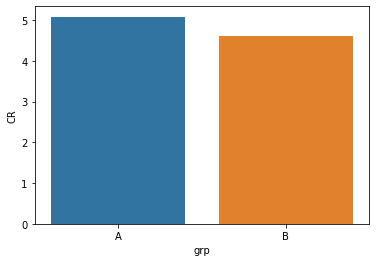

In [35]:
#Визуализируем конверсию в % в покупку по группам
sns.barplot(data = AB_conv, x = 'grp', y = 'CR')

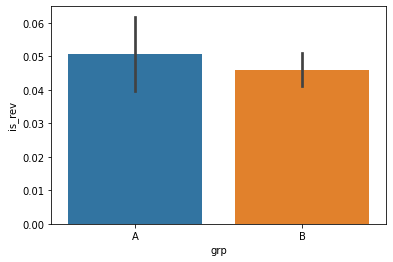

In [37]:
#Визуализируем распределение наличия покупки у пользователя в покупку по группам в долях
sns.barplot(data = AB_data, x = 'grp', y = 'is_rev')

Визуализация показала, уменьшение конверсии в покупку в целевой группе.

Для оценки статистической значимости изменений из-за диспропорции выборок выбираем критерий Хи-квадрат.
Обозначим наши гипотезы:
- $H_0$: Нет статистически значимого различия в конверсиях между группами. 
- $H_1$: Существует статистически значимое различие в конверсиях между группами.

In [38]:
pd.crosstab(AB_data.grp, AB_data.is_rev) # построим кросс таблицу для категориальных переменных

is_rev,0,1
grp,,
A,1457,78
B,6480,313


In [39]:
from scipy.stats import chi2_contingency, chi2 # импортируем метод

In [40]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(AB_data.grp, AB_data.is_rev)) # задаем переменные

In [41]:
stat, p # смотрим на величину хи-квадрата и Р-value

(0.526607176998989, 0.46803677583199144)

In [42]:
prob = 0.95
alfa = 1-prob
if p<= alfa:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


#### Вывод по применению критерия Хи-квадрат:
У нас недостаточно оснований, чтобы отклонить нулевую гипотезу об отсутствии статистически значимого различия между группами.
Следовательно уменьшение CR не является статистически значимым. Новая механика оплаты услуг на конверсию посещения в покупку не повлияла.

#### 2. Анализ среднего чека:

In [43]:
#Оставляем только данные с совершенными покупками
AB_avg_check = AB_data.dropna()

In [44]:
AB_avg_check.describe()

,student_id,rev,is_rev
count,3.910000e+02,391.000000,391.0
mean,2.841290e+06,1191.544766,1.0
std,1.613827e+06,827.421317,0.0
min,1.627000e+03,199.000000,1.0
25%,1.317094e+06,290.000000,1.0
50%,3.110897e+06,990.000000,1.0
75%,4.219794e+06,1900.000000,1.0
max,5.681918e+06,4650.000000,1.0


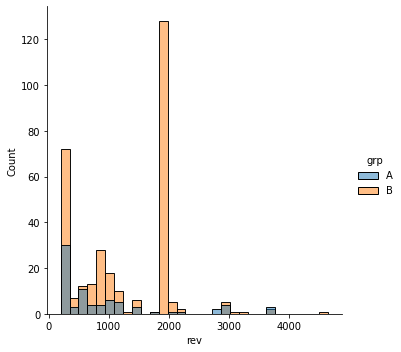

In [45]:
# Визуализируем распределение по размеру чека в разных группах
sns.displot(data=AB_avg_check, x="rev", hue="grp", bins = 30)

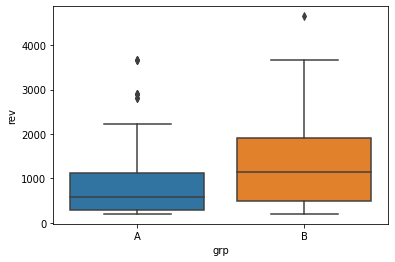

In [46]:
# Визуализируем наши распределения.
sns.boxplot(x = 'grp', y = 'rev', data = AB_avg_check)

In [52]:
AB_avg = AB_avg_check.groupby('grp', as_index = False).agg({'rev': 'sum', 'is_rev':'sum'})

In [53]:
AB_avg['avg_check'] = (AB_avg['rev']/AB_avg['is_rev']).round(2)

In [54]:
AB_avg

,grp,rev,is_rev,avg_check
0,A,72820.0000,78,933.59
1,B,393074.0035,313,1255.83


In [55]:
AB_avg_check

,student_id,grp,rev,is_rev
61,1184303,A,1530.0000,1
66,3354191,B,1900.0001,1
76,3278734,B,1900.0000,1
98,720651,A,1980.0000,1
191,1232221,B,1900.0000,1
...,...,...,...,...
8188,3890326,B,199.0000,1
8191,1390994,A,398.0000,1
8250,1516339,A,290.0000,1
8264,3910596,B,597.0000,1


In [56]:
AB_avg_check.rev.describe()

count     391.000000
mean     1191.544766
std       827.421317
min       199.000000
25%       290.000000
50%       990.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

По результатам изучения данных по покупкам и их визуализации мы видим:
 - неравномерные выборки;
 - ненормальное распределение значений;
 - большое стандартное отклонение;
 - средний чек в целевой группе выше, чем в контрольной.
 
 Для проверки являются ли наши различия в среднем чеке статистически значимыми, с учетом особенностей выборок, воспользуемся Бутстрепом.
 
 Обозначим наши гипотезы:
- $H_0$: Средние значения чека в двух группах равны.
- $H_1$: Средние значения чека в двух группах различаются.
 

In [57]:
# выделяем контрольную группу
control_df = AB_avg_check[AB_avg_check.grp == 'A'].rev

In [58]:
# выделяем тестовую группу
test_df = AB_avg_check[AB_avg_check.grp == 'B'].rev

In [59]:
# задаем количество итерраций в бутстрепе
n = 100000

In [62]:
# Создаем пустой список для сохранения результатов
bootstrap_means_diff = []

# Выполняем бутстреп
for i in range(n):
    # Ресэмплируем из большей выборки с заменой до размера меньшей выборки
    resampled_test = np.random.choice(test_df, size=len(control_df), replace=True)
    
    sample_control = np.random.choice(control_df, size=len(control_df), replace=True)
    
    # Вычисляем среднее значение для ресэмплированной выборки и контрольной группы
    resampled_mean = np.mean(resampled_test)
    sample_control_mean = np.mean(sample_control)
    
    # Находим разницу в средних значения
    diff_mean = resampled_mean-sample_control_mean
    # Сохраняем среднее значение в список
    bootstrap_means_diff.append(diff_mean)
    
    # Вычисляем 95% доверительный интервал для среднего значения
confidence_interval = (np.percentile(bootstrap_means_diff, [2.5, 97.5])).round(2)

print("Среднее значение:", np.mean(bootstrap_means_diff))
print("95% доверительный интервал для среднего значения:", confidence_interval)


Среднее значение: 321.36477835974364
95% доверительный интервал для среднего значения: [ 47.69 583.44]


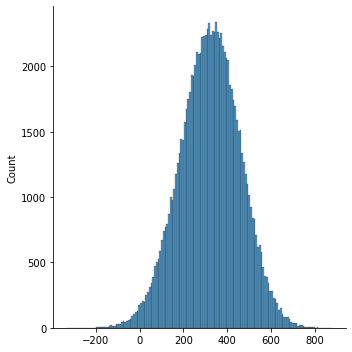

In [61]:
sns.displot(data = bootstrap_means_diff)

#### Вывод по применению Бутстрепа:
Доверительный интервал для разницы средних значений в Бутстрепе не пересекает ноль.
Следовательно у нас достаточно оснований, отклонить нулевую гипотезу и считать наши различия в среднем чеке статистически значимыми.

### Вывод по итогам А/Б - теста:
Новая механика оплаты услуг на конверсию в покупку не влияет, но есть достаточно оснований полагать, что средний чек увеличится.
Новая механика оплаты рекомендована для запуска на всех пользователей.